# Figure 3: Verification Band Map and MDC Analysis

論文 https://arxiv.org/html/2508.13845v1 の Figure 3 を再現

## パラメータ (Table 1 True values)
- m_b = 1.5875 m_e
- k_F = 0.25 Å⁻¹
- k_c = 0.1 Å⁻¹
- Γ_imp = 10.0 meV
- λ_el = 0.12
- E_F = 150 meV
- T = 10 K
- ΔE = 2.5 meV (FWHM)
- Δη = 0.1° (FWHM)

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.special import digamma
import sys
sys.path.insert(0, '..')

# 物理定数
HBAR = 6.582119569e-16  # eV·s
M_E = 9.1093837015e-31  # kg
K_B = 8.617333262e-5    # eV/K
PREF = 3.8099821161548144  # ℏ²/(2m_e) in eV·Å²

## 1. パラメータ設定

In [72]:
# True parameters (Table 1)
m_b = 1.5875  # in units of m_e
k_F = 0.25    # Å⁻¹
k_c = 0.1     # Å⁻¹ (center wavevector)
E_F = 150e-3  # eV (150 meV)
Gamma_imp = 10e-3  # eV (10 meV)
lambda_el = 0.12

# Experimental conditions
T = 10  # K
k_BT = K_B * T  # eV
Delta_E_fwhm = 2.5e-3  # eV (2.5 meV)
Delta_eta_fwhm = 0.1   # degrees
hnu_minus_Phi = 30.0   # eV

# Convert FWHM to sigma
FWHM2STD = 2 * np.sqrt(2 * np.log(2))
sigma_E = Delta_E_fwhm / FWHM2STD
sigma_eta = Delta_eta_fwhm / FWHM2STD

# Grid parameters
E_kin_min, E_kin_max = 29.8, 30.01  # eV (for -200 to +10 meV binding energy range)
eta_min, eta_max = -6.0, 10.0  # degrees
eta_step = 0.02  # degrees
N_J = 80  # number of MDC data points

# Photointensity parameters
A_0_tilde = 1e4  # counts
B_0_tilde = 0.002 * A_0_tilde  # 0.2% background
B_1_tilde = 0.0  # no linear background

# Noise parameters
mu_noise = 0.002 * A_0_tilde  # 0.2% mean
sigma_noise = 0.00025 * A_0_tilde  # 0.025% std

print(f"Energy resolution (sigma): {sigma_E*1e3:.3f} meV")
print(f"Angle resolution (sigma): {sigma_eta:.4f} degrees")
print(f"k_B T: {k_BT*1e3:.3f} meV")

Energy resolution (sigma): 1.062 meV
Angle resolution (sigma): 0.0425 degrees
k_B T: 0.862 meV


## 2. Eliashberg関数 α²F_true(ω) の生成 (Eq. 25)

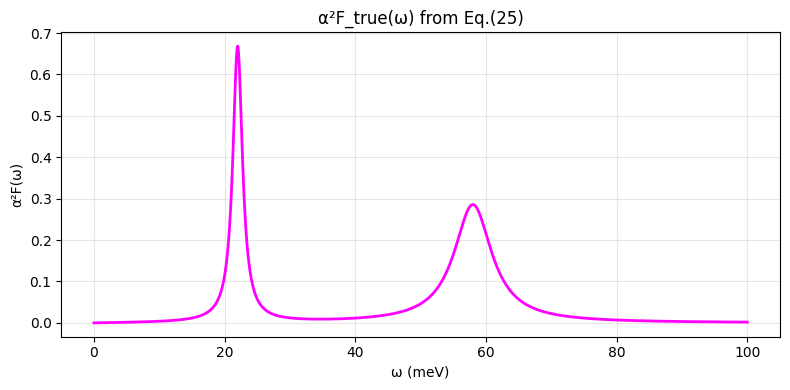

λ_ph (numerical) = 0.2781
Expected ≈ 0.28


In [73]:
import numpy as np
import matplotlib.pyplot as plt

def create_eliashberg_true(omega):
    """
    Eq. (25):
    α²F_true(ω) = Σ_{k,±} g_k² Im[ ±1 / (ω ± ω_k + iρ_k) ]
    
    ω in eV
    α²F is dimensionless
    """
    # Peak parameters (convert meV → eV)
    omega_k = np.array([22e-3, 58e-3])
    rho_k   = np.array([0.9e-3, 3.5e-3])
    g_k_sq  = np.array([0.6e-3, 1.0e-3])

    a2f = np.zeros_like(omega)

    for k in range(len(omega_k)):
        # + term
        term_plus =  1.0 / (omega + omega_k[k] + 1j * rho_k[k])
        # − term
        term_minus = -1.0 / (omega - omega_k[k] + 1j * rho_k[k])
        
        a2f += g_k_sq[k] * np.imag(term_plus + term_minus)

    return a2f


# --- Test ---
omega_test = np.linspace(1e-5, 100e-3, 2000)  # avoid ω=0 singularity
a2f_true = create_eliashberg_true(omega_test)

plt.figure(figsize=(8,4))
plt.plot(omega_test*1e3, a2f_true, 'magenta', linewidth=2)
plt.xlabel('ω (meV)')
plt.ylabel('α²F(ω)')
plt.title('α²F_true(ω) from Eq.(25)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# --- λ calculation ---
lambda_ph_true = 2 * np.trapz(a2f_true / omega_test, omega_test)
print(f"λ_ph (numerical) = {lambda_ph_true:.4f}")
print("Expected ≈ 0.28")


## 3. カーネル関数とBose-Einstein分布

In [74]:
def bose_einstein(omega, k_BT):
    """Bose-Einstein distribution n_B(omega) for k_BT > 0 and omega >= 0."""
    x_over = np.log(np.finfo(float).max)  # ~709.78 for float64
    x = omega / k_BT
    out = np.empty_like(omega, dtype=float)
    
    momega0 = (omega == 0)
    if np.any(momega0):
        out[momega0] = np.inf
    
    mpos_big = (x > x_over) & (omega != 0)
    if np.any(mpos_big):
        out[mpos_big] = 0.0
    
    mnorm = (omega != 0) & ~mpos_big
    if np.any(mnorm):
        out[mnorm] = 1.0 / np.expm1(x[mnorm])
    
    return out

def create_kernel_function(enel, omega, k_BT):
    """
    Kernel function from Eq. 17
    K(E, ω) = ψ(1/2 - i(E-ω)/(2πk_BT)) - ψ(1/2 - i(E+ω)/(2πk_BT)) 
              - 2iπ(n_B(ω) + 1/2)
    """
    enel = enel[:, None]     # (Ne, 1)
    omega = omega[None, :]   # (1, Nw)
    
    denom = 2.0 * np.pi * k_BT
    
    K = (digamma(0.5 - 1j * (enel - omega) / denom)
         - digamma(0.5 - 1j * (enel + omega) / denom)
         - 2j * np.pi * (bose_einstein(omega, k_BT) + 0.5))
    
    return K

## 4. 自己エネルギー Σ_true(E) の計算

In [75]:
def compute_sigma_ph(enel, omega, a2f, k_BT):
    """
    電子-フォノン自己エネルギー Σ^ph(E) from Eq. 17
    Σ^ph(E) = ∫ dω α²F(ω) K(E, ω)
    """
    K = create_kernel_function(enel, omega, k_BT)
    
    # Integrate over omega
    d_omega = omega[1] - omega[0]
    sigma_ph = np.sum(a2f[None, :] * K, axis=1) * d_omega
    
    return sigma_ph

def compute_sigma_el(enel, lambda_el, W):
    """
    電子-電子自己エネルギー Σ^el(E)
    Paper Figure 3a shows linear real part: Σ^el'(E) ≈ -λ_el * E
    Imaginary part: Σ^el''(E) = -λ_el * E²/W
    """
    # Real part: linear term (from Figure 3a, Σ^el' goes from ~5 meV at -80 meV to 0 at E=0)
    # This gives a slope of approximately lambda_el
    sigma_el_real = -lambda_el * enel
    
    # Imaginary part: -iλ_el * E²/W
    sigma_el_imag = -lambda_el * enel**2 / W
    
    return sigma_el_real + 1j * sigma_el_imag

def compute_sigma_imp(Gamma_imp, size):
    """
    電子-不純物自己エネルギー Σ^imp = -iΓ_imp
    """
    return -1j * Gamma_imp * np.ones(size)

# Energy grid for self-energy
E_min, E_max = -80e-3, 10e-3  # -80 to 10 meV
N_E = 500
enel = np.linspace(E_min, E_max, N_E)

# Omega grid for α²F
omega = np.linspace(0.1e-3, 100e-3, 400)  # 0.1 to 100 meV
a2f_true = create_eliashberg_true(omega)

# Compute components
print("Computing Σ^ph(E)...")
sigma_ph = compute_sigma_ph(enel, omega, a2f_true, k_BT)

print("Computing Σ^el(E)...")
W = E_F  # Set W = E_F
sigma_el = compute_sigma_el(enel, lambda_el, W)

print("Computing Σ^imp...")
sigma_imp = compute_sigma_imp(Gamma_imp, len(enel))

# Total self-energy
sigma_true = sigma_ph + sigma_el + sigma_imp

print("\nSelf-energy computation complete.")

Computing Σ^ph(E)...
Computing Σ^el(E)...
Computing Σ^imp...

Self-energy computation complete.


## 5. Figure 3a: 自己エネルギーのプロット

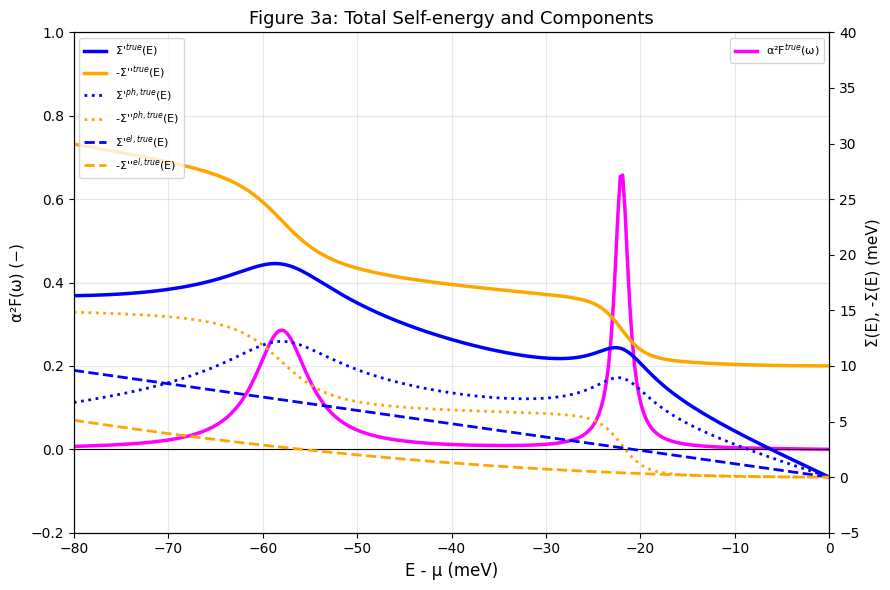


Figure 3a completed (with α²F on right axis)


In [76]:
# Create figure with dual y-axis (swapped: α²F on left, self-energy on right)
fig, ax1 = plt.subplots(1, 1, figsize=(9, 6))
ax2 = ax1.twinx()  # Second y-axis for self-energy

# α²F(ω) on left y-axis (shift x-axis to match E - μ - ω)
# Plot α²F(ω) vs (E-μ-ω) → x-axis becomes -ω values
omega_plot_x = -omega * 1e3  # Convert to meV and negate
ax1.plot(omega_plot_x, a2f_true, 'magenta', linewidth=2.5, label='α²F$^{true}$(ω)')

# Self-energy components (right y-axis)
# Total self-energy
ax2.plot(enel * 1e3, np.real(sigma_true) * 1e3, 'b-', linewidth=2.5, label="Σ'$^{true}$(E)")
ax2.plot(enel * 1e3, -np.imag(sigma_true) * 1e3, color='orange', linewidth=2.5, label="-Σ''$^{true}$(E)")

# Phonon component (dotted)
ax2.plot(enel * 1e3, np.real(sigma_ph) * 1e3, 'b:', linewidth=2, label="Σ'$^{ph,true}$(E)")
ax2.plot(enel * 1e3, -np.imag(sigma_ph) * 1e3, color='orange', linestyle=':', linewidth=2, label="-Σ''$^{ph,true}$(E)")

# Electron component (dashed)
ax2.plot(enel * 1e3, np.real(sigma_el) * 1e3, 'b--', linewidth=2, label="Σ'$^{el,true}$(E)")
ax2.plot(enel * 1e3, -np.imag(sigma_el) * 1e3, color='orange', linestyle='--', linewidth=2, label="-Σ''$^{el,true}$(E)")

# Set axis labels and limits
ax1.set_xlabel('E - μ (meV)', fontsize=12)
ax1.set_ylabel('α²F(ω) (−)', fontsize=11)  # Left axis: α²F (Dimensionless)
ax2.set_ylabel('Σ(E), -Σ(E) (meV)', fontsize=11, color='k')  # Right axis: Self-energy

# Set x-axis range to match paper (-80 to 0 meV)
ax1.set_xlim(-80, 0)
ax1.set_ylim(-0.2, 1.0)  # α²F range
ax2.set_ylim(-5, 40)     # Self-energy range

# Style
ax1.grid(True, alpha=0.3)
ax1.axhline(0, color='k', linewidth=0.8)
ax1.axvline(0, color='gray', linewidth=0.8, linestyle=':')

# Legends (swapped positions)
ax1.legend(fontsize=8, loc='upper right')  # α²F legend on right
ax2.legend(fontsize=8, loc='upper left')   # Self-energy legend on left
ax1.tick_params(axis='y')  # Left axis color

ax1.set_title('Figure 3a: Total Self-energy and Components', fontsize=13)

plt.tight_layout()
plt.savefig('figures/fig3a_self_energy.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure 3a completed (with α²F on right axis)")

## 6. 非相互作用分散 ε(k)

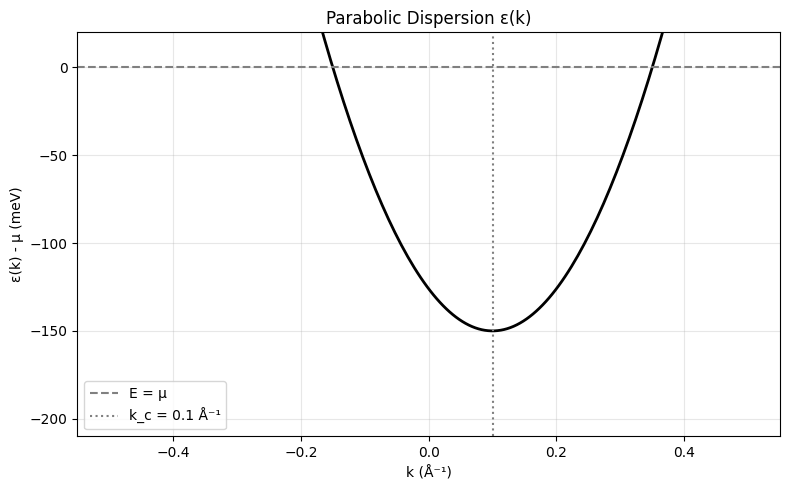

In [77]:
def epsilon_parabolic(k, m_b, k_c, k_F):
    """
    Parabolic dispersion: ε(k) = ℏ²(k - k_c)²/(2m_b) - E_F
    where E_F = ℏ²k_F²/(2m_b)
    """
    E_F = PREF * k_F**2 / m_b
    return PREF * (k - k_c)**2 / m_b - E_F

def k_from_angle(eta, E_kin):
    """
    Wavevector from angle: k = sqrt(E_kin/PREF) * sin(η)
    """
    return np.sqrt(E_kin / PREF) * np.sin(np.deg2rad(eta))

# Test dispersion
k_test = np.linspace(-0.5, 0.5, 200)
eps_test = epsilon_parabolic(k_test, m_b, k_c, k_F)

plt.figure(figsize=(8, 5))
plt.plot(k_test, eps_test * 1e3, 'k-', linewidth=2)
plt.axhline(0, color='gray', linestyle='--', label='E = μ')
plt.axvline(k_c, color='gray', linestyle=':', label=f'k_c = {k_c} Å⁻¹')
plt.xlabel('k (Å⁻¹)')
plt.ylabel('ε(k) - μ (meV)')
plt.title('Parabolic Dispersion ε(k)')

# Limit y-axis to ARPES measurement range
plt.ylim(-210, 20)

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figures/dispersion.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. スペクトル関数 A(E,k) の計算 (Eq. 4)

In [78]:
def spectral_function(E, eps_k, sigma_real, sigma_imag):
    """
    Spectral function from Eq. 4:
    A(E,k) = (1/π) * [-Σ''(E,k)] / [(E - ε(k) - Σ'(E,k))² + [Σ''(E,k)]²]
    """
    numerator = -sigma_imag
    denominator = (E - eps_k - sigma_real)**2 + sigma_imag**2
    return (1.0 / np.pi) * numerator / denominator

def fermi_dirac(E, mu, k_BT):
    """Fermi-Dirac distribution"""
    x = (E - mu) / k_BT
    x_clip = np.clip(x, -500, 500)
    return 1.0 / (np.exp(x_clip) + 1.0)

## 8. ARPES強度マップ P*(E_kin, η) の生成

In [79]:
# Create finer grids for intensity map
N_ekin = 200
N_eta = int((eta_max - eta_min) / eta_step) + 1

E_kin_grid = np.linspace(E_kin_min, E_kin_max, N_ekin)
eta_grid = np.linspace(eta_min, eta_max, N_eta)

print(f"Grid size: {N_ekin} x {N_eta} = {N_ekin * N_eta} points")

# Create 2D meshgrid
ETA, EKIN = np.meshgrid(eta_grid, E_kin_grid)

# Convert to binding energy and wavevector
ENEL = EKIN - hnu_minus_Phi  # Binding energy E - μ
K = k_from_angle(ETA, EKIN)   # Wavevector k

print(f"E_nel range: [{ENEL.min()*1e3:.1f}, {ENEL.max()*1e3:.1f}] meV")
print(f"k range: [{K.min():.3f}, {K.max():.3f}] Å⁻¹")

Grid size: 200 x 801 = 160200 points
E_nel range: [-200.0, 10.0] meV
k range: [-0.293, 0.487] Å⁻¹


In [80]:
# Compute dispersion for each k
print("Computing ε(k)...")
EPS = epsilon_parabolic(K, m_b, k_c, k_F)

# Interpolate self-energy to the grid
print("Interpolating self-energy...")
sigma_real_interp = np.interp(ENEL.flatten(), enel, np.real(sigma_true)).reshape(ENEL.shape)
sigma_imag_interp = np.interp(ENEL.flatten(), enel, np.imag(sigma_true)).reshape(ENEL.shape)

# Compute spectral function
print("Computing A(E,k)...")
A = spectral_function(ENEL, EPS, sigma_real_interp, sigma_imag_interp)

# Compute Fermi-Dirac factor
print("Computing f(E)...")
FD = fermi_dirac(ENEL, 0.0, k_BT)

# Photointensity (before convolution and noise)
print("Computing intensity...")
background = B_0_tilde + B_1_tilde * ETA
I_0 = (A_0_tilde + background) * A * FD

print(f"Intensity range: [{I_0.min():.1f}, {I_0.max():.1f}] counts")

Computing ε(k)...
Interpolating self-energy...
Computing A(E,k)...
Computing f(E)...
Computing intensity...
Intensity range: [0.0, 317009.8] counts


## 9. 分解能効果（ガウス畳み込み）

In [81]:
# Convert sigma to pixel units
d_ekin = E_kin_grid[1] - E_kin_grid[0]
d_eta = eta_grid[1] - eta_grid[0]

sigma_ekin_pixels = sigma_E / d_ekin
sigma_eta_pixels = sigma_eta / d_eta

print(f"Convolution sigma: ({sigma_ekin_pixels:.2f}, {sigma_eta_pixels:.2f}) pixels")

# Apply Gaussian filter
print("Applying Gaussian convolution...")
I_conv = gaussian_filter(I_0, sigma=(sigma_ekin_pixels, sigma_eta_pixels), mode='constant')

print("Convolution complete.")

Convolution sigma: (1.01, 2.12) pixels
Applying Gaussian convolution...
Convolution complete.


## 10. ノイズ追加

In [82]:
# Add Gaussian noise
np.random.seed(42)  # For reproducibility
noise = np.random.normal(mu_noise, sigma_noise, I_conv.shape)

P_star = I_conv + noise
P_star = np.maximum(P_star, 0)  # Ensure non-negative

print(f"Final intensity range: [{P_star.min():.1f}, {P_star.max():.1f}] counts")
print(f"Mean intensity: {P_star.mean():.1f} counts")
print(f"SNR: {P_star.mean() / sigma_noise:.1f}")

Final intensity range: [11.9, 295994.9] counts
Mean intensity: 24238.0 counts
SNR: 9695.2


## 11. Figure 3b: ARPES強度マップのプロット

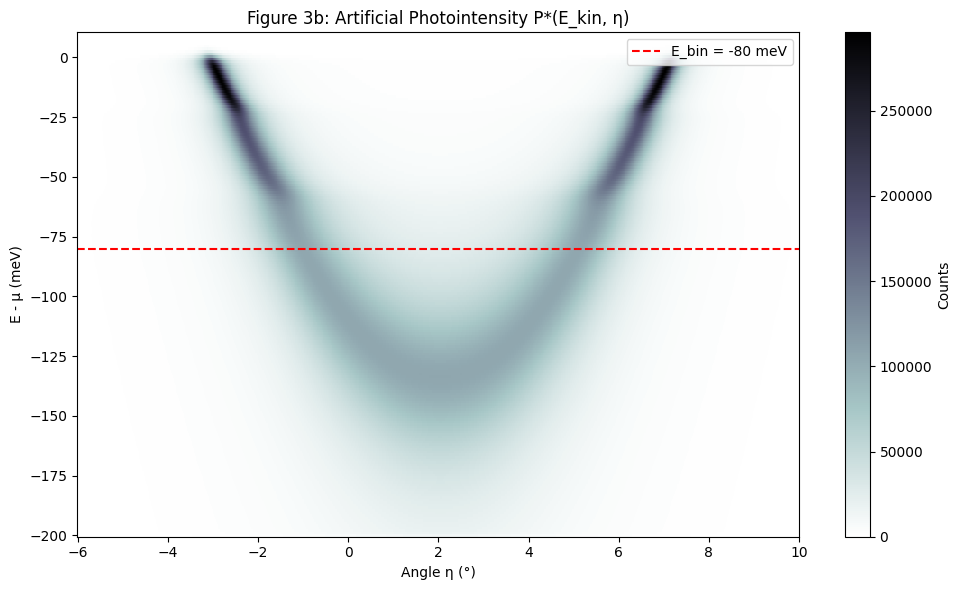

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Convert to binding energy for plotting
E_bin_grid = E_kin_grid - hnu_minus_Phi

mesh = ax.pcolormesh(eta_grid, E_bin_grid * 1e3, P_star, 
                     shading='auto', cmap='bone_r', vmin=0)

# Add line at E_bin = -80 meV (for MDC in Fig 3c)
E_bin_selected = -80e-3  # -80 meV
ax.axhline(E_bin_selected * 1e3, color='red', linestyle='--', linewidth=1.5, 
           label=f'E_bin = {E_bin_selected*1e3:.0f} meV')

ax.set_xlabel('Angle η (°)')
ax.set_ylabel('E - μ (meV)')
ax.set_title('Figure 3b: Artificial Photointensity P*(E_kin, η)')
ax.legend(loc='upper right')
plt.colorbar(mesh, ax=ax, label='Counts')

plt.tight_layout()
plt.savefig('figures/fig3b_intensity_map.png', dpi=150, bbox_inches='tight')
plt.show()

NameError: name 'E_kin_1d' is not defined

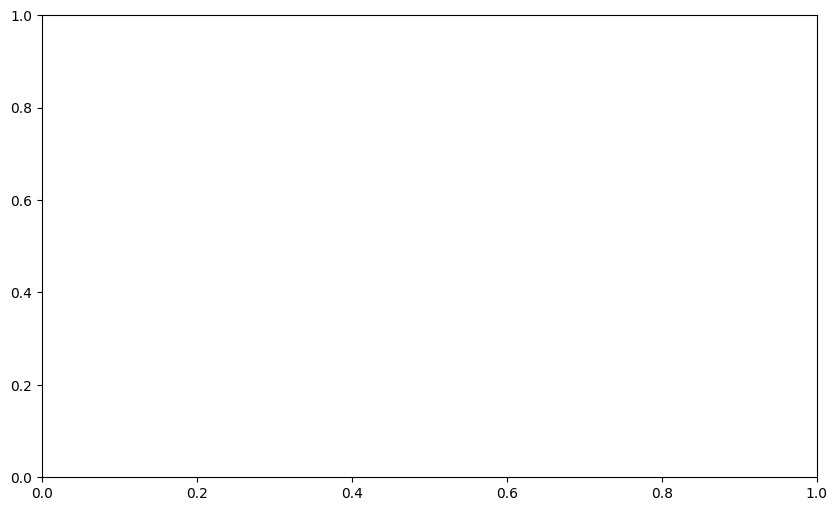

In [84]:
## Figure 3b (k-space version): ARPES強度マップ（k空間）

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Use existing K grid (already computed in Cell 18)
# K = k_from_angle(ETA, EKIN)

# Convert to binding energy for plotting
E_bin_grid_2d = EKIN - hnu_minus_Phi

mesh = ax.pcolormesh(K, E_bin_grid_2d * 1e3, P_star, 
                     shading='auto', cmap='bone_r', vmin=0)

# Add line at E_bin = -80 meV (for MDC in Fig 3c)
E_bin_selected = -80e-3  # -80 meV
ax.axhline(E_bin_selected * 1e3, color='red', linestyle='--', linewidth=1.5, 
           label=f'E_bin = {E_bin_selected*1e3:.0f} meV')

# Add vertical line at k_c
ax.axvline(k_c, color='blue', linestyle=':', linewidth=1.5, 
           label=f'k_c = {k_c:.3f} Å⁻¹')

ax.set_xlabel('k (Å⁻¹)')
ax.set_ylabel('E - μ (meV)')
ax.set_title('Figure 3b (k-space): Artificial Photointensity P*(E, k)')
ax.legend(loc='upper right')
plt.colorbar(mesh, ax=ax, label='Counts')

plt.tight_layout()
plt.savefig('figures/fig3b_intensity_map_kspace.png', dpi=150, bbox_inches='tight')
plt.show()

## 12. データ保存

In [ ]:
# Save data
np.savez('data/verification_data.npz',
         # Grids
         E_kin_grid=E_kin_grid,
         eta_grid=eta_grid,
         enel=enel,
         omega=omega,
         # Intensity
         P_star=P_star,
         # Self-energy
         sigma_true=sigma_true,
         sigma_ph=sigma_ph,
         sigma_el=sigma_el,
         sigma_imp=sigma_imp,
         # Eliashberg function
         a2f_true=a2f_true,
         # Parameters
         m_b=m_b,
         k_F=k_F,
         k_c=k_c,
         E_F=E_F,
         Gamma_imp=Gamma_imp,
         lambda_el=lambda_el,
         T=T,
         hnu_minus_Phi=hnu_minus_Phi)

print("Data saved to data/verification_data.npz")

Data saved to data/verification_data.npz


## 13. MDC抽出 (Figure 3c用)

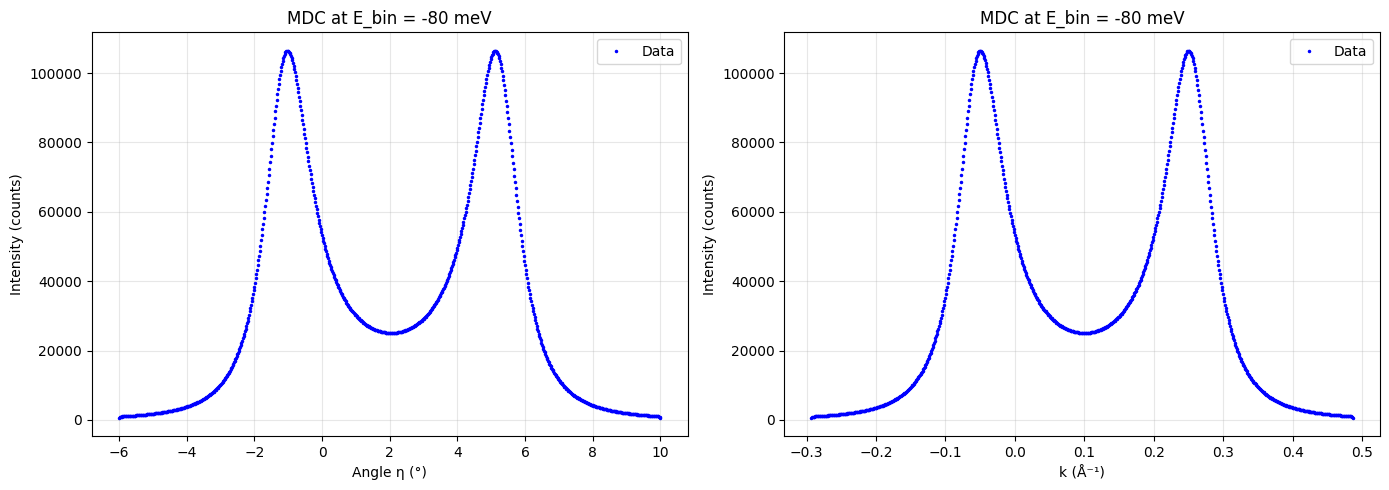


MDC extracted at E_bin = -80 meV
E_kin = 29.9203 eV
k range: [-0.293, 0.487] Å⁻¹


In [ ]:
# Extract MDC at E_bin = -80 meV
E_bin_selected = -80e-3
# Convert kinetic energy to binding energy
E_bin_grid = E_kin_grid - hnu_minus_Phi
idx_E = np.argmin(np.abs(E_bin_grid - E_bin_selected))

mdc_intensity = P_star[idx_E, :]
mdc_eta = eta_grid
mdc_k = k_from_angle(mdc_eta, E_kin_grid[idx_E])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot vs angle
ax1.plot(mdc_eta, mdc_intensity, 'b.', markersize=3, label='Data')
ax1.set_xlabel('Angle η (°)')
ax1.set_ylabel('Intensity (counts)')
ax1.set_title(f'MDC at E_bin = {E_bin_selected*1e3:.0f} meV')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot vs wavevector
ax2.plot(mdc_k, mdc_intensity, 'b.', markersize=3, label='Data')
ax2.set_xlabel('k (Å⁻¹)')
ax2.set_ylabel('Intensity (counts)')
ax2.set_title(f'MDC at E_bin = {E_bin_selected*1e3:.0f} meV')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig('figures/fig3c_mdc.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nMDC extracted at E_bin = {E_bin_selected*1e3:.0f} meV")
print(f"E_kin = {E_kin_grid[idx_E]:.4f} eV")
print(f"k range: [{mdc_k.min():.3f}, {mdc_k.max():.3f}] Å⁻¹")

## 完了

論文Figure 3の人工データ生成が完了しました。

生成されたファイル:
- `data/verification_data.npz`: 全データ
- `figures/a2f_true.png`: Eliashberg関数
- `figures/fig3a_self_energy.png`: 自己エネルギー
- `figures/dispersion.png`: 分散関係
- `figures/fig3b_intensity_map.png`: ARPES強度マップ
- `figures/fig3c_mdc.png`: MDC